The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


# 小批量随机梯度下降
:label:`sec_minibatch_sgd`

([本节](https://github.com/d2l-ai/d2l-zh/tree/release/chapter_optimization)是机器翻译，欢迎[改进](https://zh.d2l.ai/chapter_appendix/how-to-contribute.html))

到目前为止，我们在基于渐变的学习方法中遇到了两个极端情况：: :numref:`sec_gd` 使用完整数据集来计算渐变和更新参数，一次一次一次。相反，:numref:`sec_sgd` 一次处理一个训练示例以取得进展。他们中的任何一个都有自己的缺点。每当数据非常相似时，梯度下降并不特别 * 数据效率 *。随机梯度下降并不特别 * 计算效率 *，因为 CPU 和 GPU 无法充分利用矢量化的全部力量。这表明两者之间可能有一些东西，事实上，这就是我们迄今为止在我们讨论的例子中使用的东西。

## 矢量化和缓存

使用迷你手表的决定的核心是计算效率。考虑与多个 GPU 和多台服务器并行处理时，最容易理解这一点。在这种情况下，我们需要向每个 GPU 发送至少一张图像。有了每台服务器 8 个 GPU 和 16 台服务器，我们已经到达了不小于 128 个的迷你批量。

当涉及到单个 GPU 甚至 CPU 时，事情会更微妙一些。这些设备有多种类型的内存，通常是多种类型的计算单元以及它们之间的带宽限制不同。例如，CPU 有少量寄存器，然后是 L1、L2，在某些情况下甚至是 L3 缓存（在不同的处理器内核之间共享）。这些缓存的大小和延迟都在增加（同时它们的带宽也在减少）。可以说，处理器能够执行比主内存接口能够提供的操作多得多。

首先，具有 16 个内核和 AVX-512 矢量化的 2GHz CPU 每秒可处理高达 $2 \cdot 10^9 \cdot 16 \cdot 32 = 10^{12}$ 个字节。GPU 的能力很容易超过该数字 100 倍。另一方面，中端服务器处理器的带宽可能不超过 100 Gb/s，即不到保持处理器供给所需的十分之一。更糟糕的是，并非所有的内存访问都是平等的：内存接口通常为 64 位或更宽（例如，在最多 384 位的 GPU 上），因此读取单个字节会产生更广泛访问的成本。

其次，第一次访问的开销很大，而顺序访问相对便宜（这通常称为突发读取）。还有很多事情要记住，比如当我们有多个套接字、切片和其他结构时进行缓存。有关更深入的讨论，请参阅此 [Wikipedia article](https://en.wikipedia.org/wiki/Cache_hierarchy)。

缓解这些限制的方法是使用实际上足够快的 CPU 缓存层次结构，以便为处理器提供数据。这是深度学习中批量处理背后的 * 推动力。为了简单起见，请考虑矩阵-矩阵乘法，比如 $\mathbf{A} = \mathbf{B}\mathbf{C}$。我们有很多选择来计算 $\mathbf{A}$。例如，我们可以尝试以下方法：

1. 我们可以计算 $\mathbf{A}_{ij} = \mathbf{B}_{i,:} \mathbf{C}_{:,j}^\top$，也就是说，我们可以通过点积进行元素计算。
1. 我们可以计算 $\mathbf{A}_{:,j} = \mathbf{B} \mathbf{C}_{:,j}^\top$，也就是说，我们可以一次计算一列。同样，我们可以一次计算 $\mathbf{A}$ 一行 $\mathbf{A}_{i,:}$。
1. 我们可以简单地计算 $\mathbf{A} = \mathbf{B} \mathbf{C}$。
1. 我们可以将 $\mathbf{B}$ 和 $\mathbf{C}$ 分成较小的区块矩阵，然后一次计算一个区块 $\mathbf{A}$。

如果我们遵循第一个选项，每次我们想计算一个元素 $\mathbf{A}_{ij}$ 时，我们都需要将一行和一列向量复制到 CPU 中。更糟糕的是，由于矩阵元素是按顺序对齐的事实，因此，当我们从内存中读取它们时，我们需要访问两个向量中的一个的许多不相交位置。第二种选择更有利。在其中，我们能够在继续遍历 $\mathbf{B}$ 的同时，将列矢量 $\mathbf{C}_{:,j}$ 保留在 CPU 缓存中。这将内存带宽需求减半，相应地更快的访问速度。当然，备选方案 3 是最可取的。不幸的是，大多数矩阵可能不完全放入缓存中（毕竟这就是我们正在讨论的内容）。但是，选项 4 提供了一个实际有用的替代方案：我们可以将矩阵的块移动到缓存中然后在本地乘以它们。优化的图书馆会为我们处理这个问题。让我们来看看这些操作在实践中的效率如何。

除了计算效率之外，Python 和深度学习框架本身引入的开销是相当大的。回想一下，每次我们执行命令时，Python 解释器都会向 MxNet 引擎发送一个命令，该引擎需要将其插入到计算图中并在调度过程中处理它。这样的开销可能是非常有害的。简而言之，最好尽可能使用矢量化（和矩阵）。


In [1]:
%matplotlib inline
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

timer = d2l.Timer()
A = torch.zeros(256, 256)
B = torch.randn(256, 256)
C = torch.randn(256, 256)

元素分配只需遍历分别为 $\mathbf{B}$ 和 $\mathbf{C}$ 的所有行和列，即可将该值分配给 $\mathbf{A}$。


In [2]:
# Compute A = BC one element at a time
timer.start()
for i in range(256):
    for j in range(256):
        A[i, j] = torch.dot(B[i, :], C[:, j])
timer.stop()

1.0175886154174805

更快的策略是执行按列分配。


In [3]:
# Compute A = BC one column at a time
timer.start()
for j in range(256):
    A[:, j] = torch.mv(B, C[:, j])
timer.stop()

0.009322166442871094

最后，最有效的方法是在一个区块中执行整个操作。让我们看看各自的操作速度是多少。


In [4]:
# Compute A = BC in one go
timer.start()
A = torch.mm(B, C)
timer.stop()

# Multiply and add count as separate operations (fused in practice)
gigaflops = [2/i for i in timer.times]
print(f'performance in Gigaflops: element {gigaflops[0]:.3f}, '
      f'column {gigaflops[1]:.3f}, full {gigaflops[2]:.3f}')

performance in Gigaflops: element 1.965, column 214.542, full 3985.087


## 迷你手表

:label:`sec_minibatches`

过去，我们理所当然的是，我们会读取数据的 *迷你atches*，而不是单个观测数据来更新参数。我们现在为此简要说明理由。处理单个观测值需要我们执行许多单一矩阵矢量（甚至矢量-矢量）乘法，这相当昂贵，而且代表底层深度学习框架造成了巨大的开销。这既适用于在应用于数据（通常称为推理）时评估网络，也适用于计算渐变以更新参数时。也就是说，每当我们执行 $\mathbf{w} \leftarrow \mathbf{w} - \eta_t \mathbf{g}_t$ 时，这都适用于

$$\mathbf{g}_t = \partial_{\mathbf{w}} f(\mathbf{x}_{t}, \mathbf{w})$$

我们可以通过一次将其应用于小批观测值来提高此操作的 * 计算 * 效率。也就是说，我们将梯度 $\mathbf{g}_t$ 替换为一个小批次而不是单个观测值

$$\mathbf{g}_t = \partial_{\mathbf{w}} \frac{1}{|\mathcal{B}_t|} \sum_{i \in \mathcal{B}_t} f(\mathbf{x}_{i}, \mathbf{w})$$

让我们看看这对 $\mathbf{g}_t$ 的统计属性有什么影响：由于 $\mathbf{x}_t$ 以及迷你匹配 $\mathcal{B}_t$ 的所有元素都是从训练集中随机抽出的，因此梯度的预期保持不变。另一方面，差异显著减少。由于迷你匹配梯度由正在平均计算的 $b := |\mathcal{B}_t|$ 个独立渐变组成，因此其标准差降低了 $b^{-\frac{1}{2}}$ 的系数。这本身就是一件好事，因为这意味着更新与完整的渐变更可靠地对齐。

天真地说，这表明选择大型迷你手表 $\mathcal{B}_t$ 将是普遍可取的。唉，经过一段时间后，与计算成本的线性增长相比，标准差的额外减少是微乎其微的。实际上，我们选择一个足够大的迷你手表，可以提供良好的计算效率，同时仍然适合 GPU 的内存。为了说明节省的费用，让我们来看看一些代码。在其中我们执行相同的矩阵矩阵乘法，但是这次一次分为 64 列的 “迷你匹配”。


In [5]:
timer.start()
for j in range(0, 256, 64):
    A[:, j:j+64] = torch.mm(B, C[:, j:j+64])
timer.stop()
print(f'performance in Gigaflops: block {2 / timer.times[3]:.3f}')

performance in Gigaflops: block 2432.186


正如我们所看到的那样，迷你批量上的计算基本上与完整矩阵一样有效。有必要谨慎。在 :numref:`sec_batch_norm` 中，我们使用了一种在很大程度上取决于迷你手表中的差异量的正则化。随着后者的增加，差异会减少，随之而来的是批量标准化导致噪声注入的好处。例如，请参阅 :cite:`Ioffe.2017`，了解有关如何重新缩放和计算适当术语的详细信息。

## 阅读数据集

让我们来看看如何从数据中有效地生成迷你比赛。在下面我们使用 NASA 开发的数据集来测试翼 [noise from different aircraft](https://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise) 来比较这些优化算法。为方便起见，我们只使用前 $1,500$ 示例。为了预处理，数据已变白，也就是说，我们移除均值并将方差重新缩放到每个坐标 $1$。


In [6]:
#@save
d2l.DATA_HUB['airfoil'] = (d2l.DATA_URL + 'airfoil_self_noise.dat',
                           '76e5be1548fd8222e5074cf0faae75edff8cf93f')

#@save
def get_data_ch11(batch_size=10, n=1500):
    data = np.genfromtxt(d2l.download('airfoil'),
                         dtype=np.float32, delimiter='\t')
    data = torch.from_numpy((data - data.mean(axis=0)) / data.std(axis=0))
    data_iter = d2l.load_array((data[:n, :-1], data[:n, -1]),
                               batch_size, is_train=True)
    return data_iter, data.shape[1]-1

## 从头开始实施

回想一下 :numref:`sec_linear_scratch` 的迷你匹配随机梯度下降实现。在下面我们提供了稍微一般的实施方法。为方便起见，它与本章后面介绍的其他优化算法具有相同的调用签名。具体来说，我们添加状态输入 `states` 并将超参数放在字典 `hyperparams` 中。此外，我们将在训练函数中对每个迷你匹配示例的损失进行平均值，因此优化算法中的梯度不需要除以批量大小。


In [7]:
def sgd(params, states, hyperparams):
    for p in params:
        p.data.sub_(hyperparams['lr'] * p.grad)
        p.grad.data.zero_()

接下来，我们实施了一个通用的训练函数，以方便使用本章后面介绍的其他优化算法。它初始化了一个线性回归模型，可用于使用迷你匹配随机梯度下降和随后引入的其他算法来训练模型。


In [8]:
#@save
def train_ch11(trainer_fn, states, hyperparams, data_iter,
               feature_dim, num_epochs=2):
    # Initialization
    w = torch.normal(mean=0.0, std=0.01, size=(feature_dim, 1),
                     requires_grad=True)
    b = torch.zeros((1), requires_grad=True)
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    # Train
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            l = loss(net(X), y).mean()
            l.backward()
            trainer_fn([w, b], states, hyperparams)
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter),
                             (d2l.evaluate_loss(net, data_iter, loss),))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')
    return timer.cumsum(), animator.Y[0]

让我们来看看批量梯度下降的优化是如何进行的。这可以通过将迷你批量设置为 1500（即示例总数）来实现。因此，模型参数每个纪元只更新一次。没有什么进展。事实上，经过 6 个步骤的进度停滞。


loss: 0.246, 0.031 sec/epoch


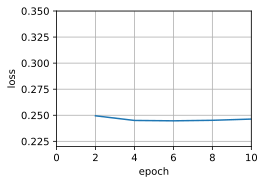

In [9]:
def train_sgd(lr, batch_size, num_epochs=2):
    data_iter, feature_dim = get_data_ch11(batch_size)
    return train_ch11(
        sgd, None, {'lr': lr}, data_iter, feature_dim, num_epochs)

gd_res = train_sgd(1, 1500, 10)

当批次大小等于 1 时，我们使用随机梯度下降进行优化。为了简单实施，我们选择了恒定（尽管很小）的学习率。在随机梯度下降中，每当处理示例时，模型参数都会更新。在我们的例子中，这相当于每个纪元 1500 次更新。正如我们所看到的那样，目标函数价值的下降在一个时代之后放缓。尽管两个程序在一个时代内处理了 1500 个示例，但在我们的实验中，随机梯度下降消耗的时间比梯度下降更多。这是因为随机梯度下降更频繁地更新了参数，而且一次处理单个观测值效率较低。


loss: 0.245, 0.077 sec/epoch


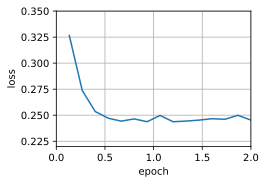

In [10]:
sgd_res = train_sgd(0.005, 1)

最后，当批次大小等于 100 时，我们使用迷你批次随机梯度下降进行优化。每个纪元所需的时间比随机梯度下降所需的时间和批量梯度下降所需的时间短。


loss: 0.247, 0.003 sec/epoch


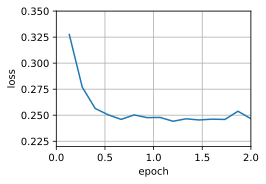

In [11]:
mini1_res = train_sgd(.4, 100)

将批量大小减少到 10，每个时代的时间都会增加，因为每个批处理的工作负载的执行效率较低。


loss: 0.244, 0.009 sec/epoch


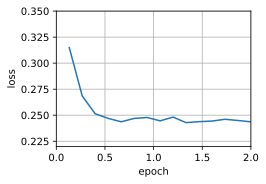

In [12]:
mini2_res = train_sgd(.05, 10)

现在我们可以比较前四个实验的时间与损失。可以看出，尽管在处理的例子数方面，随机梯度下降的收敛速度快于 GD，但与 GD 相比，它需要更多的时间来达到同样的损失，因为按例子计算梯度示例并不那么有效。迷你匹配随机梯度下降能够权衡收敛速度和计算效率。迷你批量大小为 10 比随机梯度下降更有效；100 的迷你批量在运行时间上甚至优于 GD。


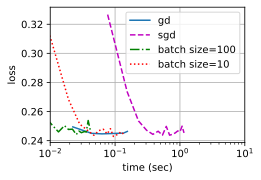

In [13]:
d2l.set_figsize([6, 3])
d2l.plot(*list(map(list, zip(gd_res, sgd_res, mini1_res, mini2_res))),
         'time (sec)', 'loss', xlim=[1e-2, 10],
         legend=['gd', 'sgd', 'batch size=100', 'batch size=10'])
d2l.plt.gca().set_xscale('log')

## 简洁的实施

在 Gluon 中，我们可以使用 `Trainer` 类调用优化算法。这用于实现通用训练功能。我们将在本章中使用它。


In [14]:
#@save
def train_concise_ch11(trainer_fn, hyperparams, data_iter, num_epochs=4):
    # Initialization
    net = nn.Sequential(nn.Linear(5, 1))
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.normal_(m.weight, std=0.01)
    net.apply(init_weights)

    optimizer = trainer_fn(net.parameters(), **hyperparams)

    loss = nn.MSELoss()
    # Note: L2 Loss = 1/2 * MSE Loss. PyTorch has MSE Loss which is slightly
    # different from MXNet's L2Loss by a factor of 2. Hence we halve the loss
    # value to get L2Loss in PyTorch
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            optimizer.zero_grad()
            out = net(X)
            y = y.reshape(out.shape)
            l = loss(out, y)/2
            l.backward()
            optimizer.step()
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter),
                             (d2l.evaluate_loss(net, data_iter, loss)/2,))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')

使用 Gluon 重复上一个实验表明相同的行为。


loss: 0.248, 0.011 sec/epoch


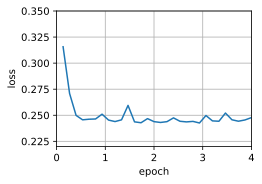

In [15]:
data_iter, _ = get_data_ch11(10)
trainer = torch.optim.SGD
train_concise_ch11(trainer, {'lr': 0.05}, data_iter)

## 摘要

* 由于减少了深度学习框架产生的开销，以及更好的内存局部性和 CPU 和 GPU 上的缓存，矢量化使代码更加高效。
* 随机梯度下降产生的统计效率与一次处理大批量数据产生的计算效率之间存在权衡。
* 迷你匹配随机梯度下降提供了两全其美：计算和统计效率。
* 在迷你匹配随机梯度下降中，我们处理通过训练数据的随机排列获得的批次数据（即，每个观测值只处理一次，尽管是随机顺序）。
* 建议在训练期间降低学习率。
* 一般来说，小批次随机梯度下降速度比随机梯度下降速度和梯度下降速度快，如果以时钟时间来衡量，收敛风险较小。

## 练习

1. 修改批次数和学习率，并观察目标函数值的下降率以及每个时代消耗的时间。
1. 阅读 MXNet 文档，然后使用 `Trainer` class `set_learning_rate` 函数将迷你匹配随机梯度下降的学习率降至每个时代之后先前值的 1/10。
1. 将迷你匹配随机梯度下降与实际 * 从训练集中取样 * 替换 * 的变体进行比较。会发生什么？
1. 邪恶的精灵在没有告诉你的情况下复制你的数据集（即，每个观测发生两次，你的数据集增加到原始大小的两倍，但没有人告诉你）。随机梯度下降、迷你匹配随机梯度下降和梯度下降的行为如何改变？


[Discussions](https://discuss.d2l.ai/t/1068)
